In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

In [2]:
image = mpimg.imread('fig.png')
# make image smaller (faster execution) and change format from [0,1] to [0,255]
image = (image[::4,::3] * 255).astype(int)

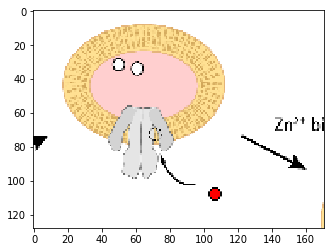

In [3]:
plt.imshow(image)
plt.show()

In [76]:
def initialize_kernels(n,k=3,c=3):
    '''
    Initialize kernels with weights and bias
        n - number of kernels/filters
        k - the size of the kernel (in pixels, square)
        c - the depth (channels)
    '''
    std = 1/np.sqrt(np.prod((n,k,k,c)))
    return np.random.normal(scale=std,size=(n,k,k,c))

def convolve(data,kernels,bias):
    '''
    Performs convolution using the given kernels and return the resulting images (summed over all channels)
        no padding
    '''
    # get parameters
    n,k,_,ch = kernels.shape
    x,y,_ = data.shape
    # create new images array (one image for each kernel)
    convolved = np.zeros([n,x-k+1,y-k+1])
    # skip on edges (left and right)
    s_l = k//2
    s_r = k-s_l-1
    # apply convolution
    for kernel in range(n):
        # merge channels
        for i in range(s_l,x-s_r):
            for j in range(s_l,y-s_r):
                # sum over all kernels
                convolved[kernel,i-s_l,j-s_l] = (data[i-s_l:i+s_r+1,j-s_l:j+s_r+1,:] 
                                                 * kernels[kernel,:,:,:]).sum() + bias[kernel]
    return convolved

def ReLU(data):
    '''Apply ReLU on the data'''
    return np.maximum(data,0)

def max_pool(data,step_size):
    '''Max pool data and reduce the number of pixels'''
    # setup parameters
    n,x,y = data.shape
    # generate output array
    pool = np.zeros((n,x//step_size,y//step_size))
    # reduce size
    for k in range(n):
        # for each kernel
        for i in range(0,x-x%step_size,step_size):
            for j in range(0,y-y%step_size,step_size):
                pool[k,i//step_size,j//step_size] = np.max(data[k,i:i+step_size,j:j+step_size])
    return pool

def d_max_pool(delta, data, step_size):
    '''
    delta of the next layer (feeding backward into the max pool, weighted and after reshaping)
        original data used during the feed forward
    '''
    # output array
    n,x,y = data.shape
    error = np.zeros(data.shape)
    # loop through x,y and kernel
    for k in range(n):
        for i in range(0,x-x%step_size,step_size):
            for j in range(0,y-y%step_size,step_size): 
                # obtain index of largest value in input for current window
                current = data[k,i:i+step_size, j:j+step_size]
                (a, b) = np.unravel_index(np.argmax(current),current.shape)
                # update error to propagate backward (only the max value is propagated)
                error[k,i+a, j+b] = delta[k,i//step_size, j//step_size]        
                # no weights to update
    return error

def d_convolve(delta, data, kernels):
    '''
    delta of the next layer (back propagating into this one)
        data was the input data to this layer on the forward-propagate
    '''
    n,k_size,_,_ = kernels.shape
    x,y,_ = data.shape
    # initialize derivatives
    error = np.zeros(data.shape) 
    d_kernels = np.zeros(kernels.shape)
    d_bias = np.zeros(n)
    for k in range(n):
        for i in range(x-k_size):
            for j in range(y-k_size): 
                # kernel weights delta
                d_kernels[k] += delta[k,i,j] * data[i:i+k_size,j:j+k_size,:]
                # error
                error[i:i+k_size,j:j+k_size,:] += delta[k,i,j] * kernels[k]
        # loss gradient of the bias
        d_bias[k] = np.sum(delta[k])
    
    return error, d_kernels, d_bias

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


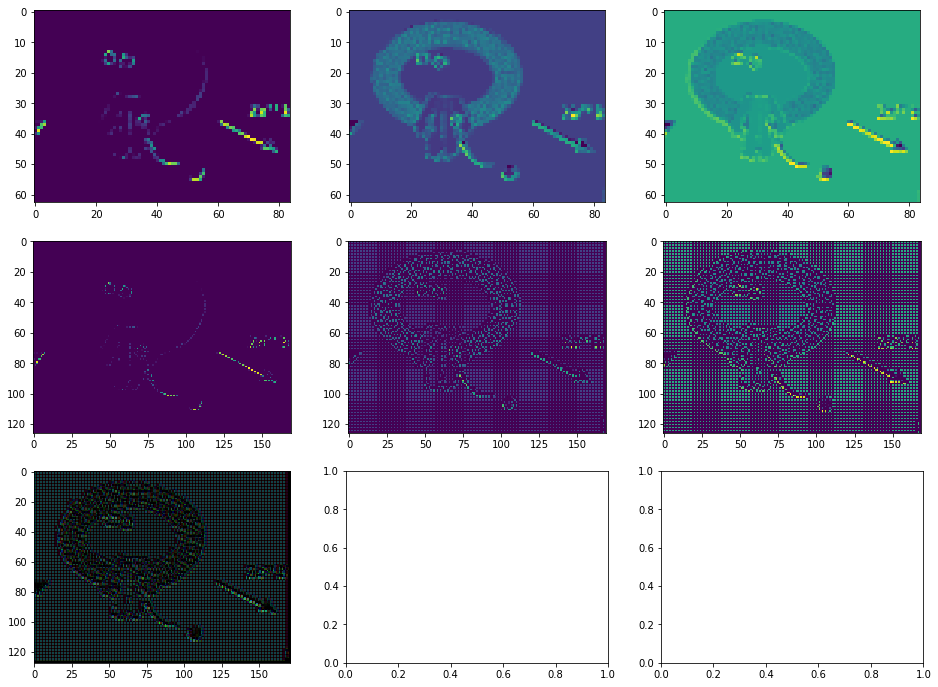

In [130]:
n = 3
kernels = initialize_kernels(n,3)
conv = convolve(image,kernels,np.zeros(n))
relu = ReLU(conv)
pool = max_pool(relu,2)
dpool = d_max_pool(pool,relu,2) # dummy test (pool is not the deltas)
a,b,c = d_convolve(dpool,image,kernels)
fig, axes = plt.subplots(nrows=3,figsize=(16,12),ncols=n)
for i in range(n):
    axes[0][i].imshow(pool[i].astype(int))    
    axes[1][i].imshow(dpool[i].astype(int))
    axes[2][0].imshow(a.astype(int))
plt.show()